In [1]:
import os

In [2]:
base = 'data/stage1_train'
dirs = os.listdir(base)

In [3]:
os.listdir(os.path.join(base, dirs[0]))

['images', 'masks']

In [4]:
id_to_image = {}
for el in dirs:
    image_dir = os.path.join(base, el, 'images')
    mask_dir = os.path.join(base, el, 'masks')
    if not os.path.exists(image_dir):
        continue
    image_id = el
    images = os.listdir(image_dir)
    images = [os.path.join(image_dir, image) for image in images]
    masks = os.listdir(mask_dir)
    masks = [os.path.join(mask_dir, mask) for mask in masks]

    id_to_image[image_id] = {}
    id_to_image[image_id]['images'] = images
    id_to_image[image_id]['masks'] = masks
    

In [5]:
id_to_image[dirs[0]]['images']

['data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png']

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

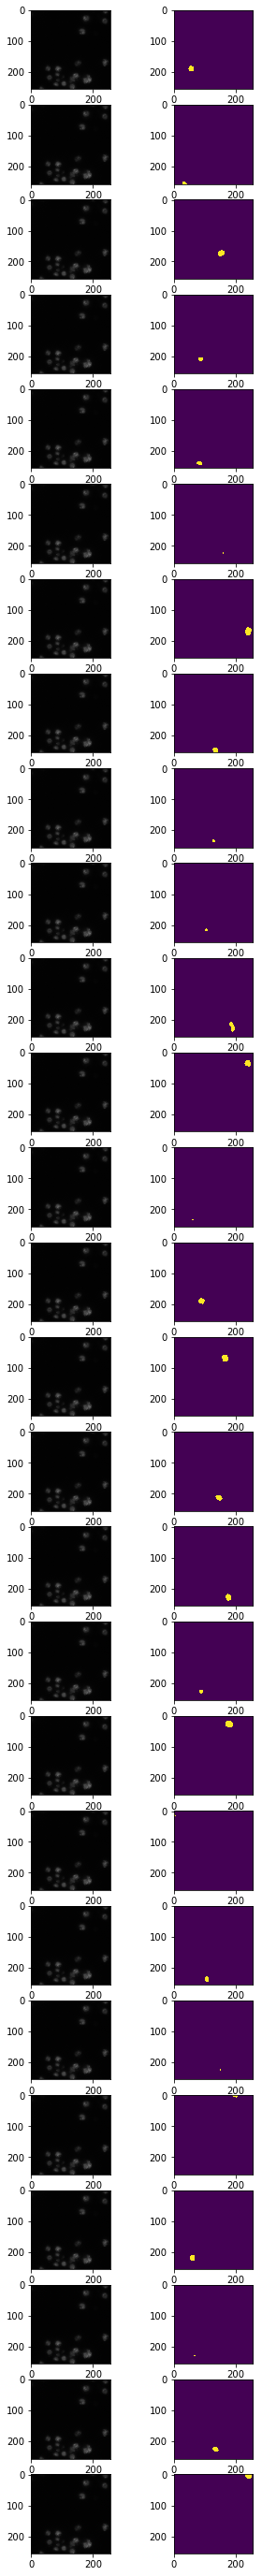

In [7]:
plt.rcParams['figure.figsize'] = (5,50)
img = mpimg.imread(id_to_image[dirs[0]]['images'][0])
masks = id_to_image[dirs[0]]['masks']
fig, axes = plt.subplots(len(masks),2)
for i in range(len(masks)):
    axes[i][0].imshow(img)
    mask = mpimg.imread(masks[i])
    axes[i][1].imshow(mask)


(array([ 430.,  136.,   49.,   31.,    9.,    6.,    4.,    2.,    1.,    2.]),
 array([   1. ,   38.4,   75.8,  113.2,  150.6,  188. ,  225.4,  262.8,
         300.2,  337.6,  375. ]),
 <a list of 10 Patch objects>)

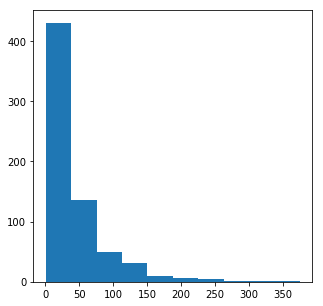

In [8]:
plt.rcParams['figure.figsize'] = (5,5)
lengths = []
for key in id_to_image.keys():
    lengths.append(len(id_to_image[key]['masks']))
plt.hist(lengths)

# Darkness


In [9]:
img = mpimg.imread(id_to_image[dirs[0]]['images'][0])
masks = id_to_image[dirs[0]]['masks']
mask = mpimg.imread(masks[i])

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

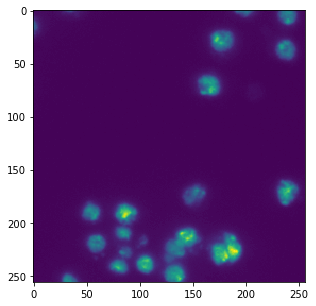

In [11]:
plt.imshow(rgb2gray(img))

In [12]:
def combine_masks(masks):
    return np.sum(np.array([ mpimg.imread(mask) for mask in masks]), axis=0)

In [13]:
combined_mask = combine_masks(masks)

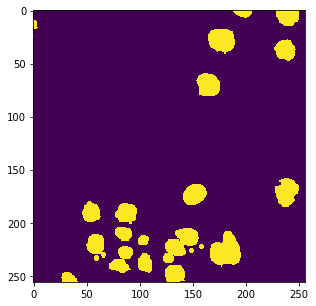

In [14]:
plt.imshow(combined_mask)

In [15]:
a = rgb2gray(img).reshape(-1)
b = combined_mask.reshape(-1)

In [16]:
a[~b.astype('bool')].shape

(59821,)

In [17]:
print(rgb2gray(img).reshape(-1).shape)
print(combined_mask.reshape(-1).shape)


(65536,)
(65536,)


In [18]:
def get_pixel_values(img, msk):
    nuclei = []
    non_nuclei = []
    

In [51]:
import sklearn
from sklearn import mixture
from sklearn import cluster
class Example:
    def __init__(self, image_path, mask_paths):
        self.image_path = image_path
        self.mask_paths = mask_paths
        self.combined_mask = self.combine_masks(self.mask_paths)
        self.image = mpimg.imread(image_path)
        self.image_shape = self.image.shape
        self.gray_image = self.rgb2gray(self.image)

    def rgb2gray(self, rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    def combine_masks(self, masks):
        return np.sum(np.array([ mpimg.imread(mask) for mask in masks]), axis=0)
    
    def nuclei_vals(self):
        flat_img = self.gray_image.reshape(-1)
        flat_msk = self.combined_mask.reshape(-1).astype('bool')
        return flat_img[flat_msk], flat_img[~flat_msk]
        
    def gaussian_mixture(self):
        self.mm = sklearn.mixture.GaussianMixture(n_components=2,init_params = 'random', verbose=True)
        self.mm.fit(self.gray_image.reshape(-1)[:, np.newaxis])
        self.means = [mm.means_[0][0], mm.means_[1][0]]
        print(self.means)
        self.covariances = [mm.covariances_[0][0][0], mm.covariances_[1][0][0]]
    
    def kmeans(self):
        self.km = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(self.gray_image.reshape(-1)[:, np.newaxis])

    def predict_kmeans(self):
        self.predictions = self.km.predict(self.gray_image.reshape(-1)[:, np.newaxis])
        if np.sum(self.predictions) > (len(self.predictions)/2.0):
            self.predictions = -(self.predictions-1)
        self.predictions = self.predictions.reshape(self.image_shape[:2])
        return self.predictions
    
    def return_string_rep(self):
        arr = []
        pixel_num = 0
        run_length = 0
        for col in range(self.predictions.shape[1]):
            for row in range(self.predictions.shape[0]):
                pixel_num += 1
                if self.predictions[row,col] == 1:
                    run_length += 1
                else:
                    if run_length > 0:
                        arr.append(str(pixel_num-run_length))
                        arr.append(str(run_length))
                        run_length = 0
        return " ".join(arr)
                    

# Training and Testing

In [52]:
all_ids = np.array([key for key in id_to_image])
np.random.seed(0)
msk = np.random.rand(len(all_ids)) < 0.8
train_ids = all_ids[msk]
val_ids = all_ids[~msk]


In [53]:
len(val_ids)

133

In [54]:
training_examples = []
i=0
for key in train_ids:
    if i % 10 == 0:
        print(i)
    i+=1
    if i > 30:
        break
    training_examples.append(Example(id_to_image[key]['images'][0], id_to_image[key]['masks']))

0
10
20
30


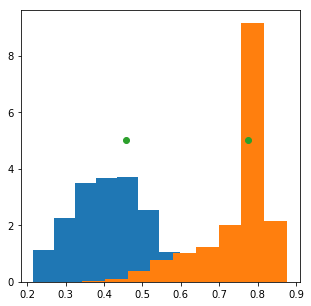

In [55]:
plt.rcParams['figure.figsize'] = (5,5)
n=3
plt.hist(training_examples[n].nuclei_vals()[0],normed=1)
plt.hist(training_examples[n].nuclei_vals()[1],normed=1)
training_examples[n].kmeans()
plt.plot(training_examples[n].km.cluster_centers_,[5,5],'o')

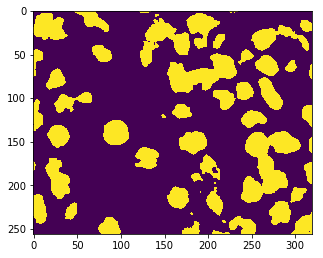

In [56]:
plt.imshow(training_examples[n].predict_kmeans())

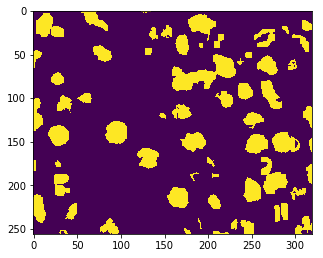

In [57]:
plt.imshow(training_examples[n].combined_mask)